## Исследование надёжности заёмщиков

Заказчик — кредитный отдел банка. Нужно разобраться, влияет ли семейное положение и количество детей клиента на факт погашения кредита в срок. Входные данные от банка — статистика о платёжеспособности клиентов.

Результаты исследования будут учтены при построении модели **кредитного скоринга** — специальной системы, которая оценивает способность потенциального заёмщика вернуть кредит банку.

### Шаг 1. Откройте файл с данными и изучите общую информацию. 

In [173]:
import pandas as pd
from pymystem3 import Mystem
from collections import Counter

In [174]:
# данные о платежеспособности
solvency = pd.read_csv('/datasets/data.csv')
solvency.head()

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose
0,1,-8437.673028,42,высшее,0,женат / замужем,0,F,сотрудник,0,253875.639453,покупка жилья
1,1,-4024.803754,36,среднее,1,женат / замужем,0,F,сотрудник,0,112080.014102,приобретение автомобиля
2,0,-5623.422610,33,Среднее,1,женат / замужем,0,M,сотрудник,0,145885.952297,покупка жилья
3,3,-4124.747207,32,среднее,1,женат / замужем,0,M,сотрудник,0,267628.550329,дополнительное образование
4,0,340266.072047,53,среднее,1,гражданский брак,1,F,пенсионер,0,158616.077870,сыграть свадьбу


In [175]:
solvency.describe()

,children,days_employed,dob_years,education_id,family_status_id,debt,total_income
count,21525.000000,19351.000000,21525.000000,21525.000000,21525.000000,21525.000000,1.935100e+04
mean,0.538908,63046.497661,43.293380,0.817236,0.972544,0.080883,1.674223e+05
std,1.381587,140827.311974,12.574584,0.548138,1.420324,0.272661,1.029716e+05
min,-1.000000,-18388.949901,0.000000,0.000000,0.000000,0.000000,2.066726e+04
25%,0.000000,-2747.423625,33.000000,1.000000,0.000000,0.000000,1.030532e+05
50%,0.000000,-1203.369529,42.000000,1.000000,0.000000,0.000000,1.450179e+05
75%,1.000000,-291.095954,53.000000,1.000000,1.000000,0.000000,2.034351e+05
max,20.000000,401755.400475,75.000000,4.000000,4.000000,1.000000,2.265604e+06


In [176]:
solvency.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21525 entries, 0 to 21524
Data columns (total 12 columns):
children            21525 non-null int64
days_employed       19351 non-null float64
dob_years           21525 non-null int64
education           21525 non-null object
education_id        21525 non-null int64
family_status       21525 non-null object
family_status_id    21525 non-null int64
gender              21525 non-null object
income_type         21525 non-null object
debt                21525 non-null int64
total_income        19351 non-null float64
purpose             21525 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 2.0+ MB


### Вывод

Таблица содержит большое количество полей, для работы потребуется только часть из них.
Данные содержат пропущенные значения, которые необходимо будет обработать.
Такие значения как уровень образования и семейное положение хранятся в виде кода и значения этого кода, их можно вынести в отдельные словари.
Данные о совокупном доходе можно привести к целочисленному виду.

### Шаг 2. Предобработка данных

### Обработка пропусков

#### Поле 'total_income'

Таблица содержит пропущенные значения в столбцах 'days_employed', 'total_income'

In [177]:
solvency.isna().sum()

children               0
days_employed       2174
dob_years              0
education              0
education_id           0
family_status          0
family_status_id       0
gender                 0
income_type            0
debt                   0
total_income        2174
purpose                0
dtype: int64

Столбец 'total_income' понадобится для того, чтобы ответить на вопрос о зависимости между уровнем дохода и возвратом кредита в срок. Поэтому для него обработаем значения NaN. Выделим заемщиков, по которым не указана сумму дохода (NaN) в отдельную категорию. Для этого заполненим пропуски значением "-1", чтобы затем можно было выделить отдельную категорию "Доход не указан".

In [178]:
solvency.loc[solvency['total_income'].isnull() == True, 'total_income'] = -1

#### Поле 'children'

В столбце 'children' присутствуют значения, которые сложно правильно интерпретировать. "-1" - вероятно значение было пропущено, а в базе, в которой ведется заполнение анкеты, пропущенное значение соответствует "-1". Оставим это значение без изменения и в дальнейшем исключим его при анализе.
Есть количество "20", причем даже у заемщиков 21-27 лет, что говорит о возможной ошибке. Можно предположить, что значение введено ошибочно вместо 2. Однако, это не точно и если мы сделаем замену, мы можем исказить статистику по людям с 2 детьми. 
Оценим медианное значение по задолженности для всех данных в целом и для для заемщиков с 20 детьми.
Медианное значение одинаковое для обоих случаев, поэтому для оценки влияния наличия детей на срок возврата, 
мы можем исключить эти строки из данных. Для этого заменим значение "20" на "-1".

In [179]:
# сравнение медиан
print(solvency['debt'].median())
print(solvency.loc[solvency['children'] == 20]['debt'].median())

0.0
0.0


In [180]:
# исключение значения 20 из данных
solvency.loc[solvency['children'] == 20, 'children'] = -1

### Вывод

Выполнена замена пропущенных данных. В поле 'total_income' по значению "-1" будет выделена категория "Доход не указан". В поле "children" значения со значением -1 будут удалены из данных при поиске зависимости.

### Замена типа данных

Данные в столбце 'total_income' имеют тип float64, для преобразования в int64 используем метод astype(). Т.к. при преобразовании значений NaN может возникнуть ошибка, добавим try-except.

In [181]:
try:
    solvency['total_income'] = solvency['total_income'].astype('int')
except:
    solvency.loc[solvency['total_income'].isnull() == True, 'total_income'] = -1
    solvency['total_income'] = solvency['total_income'].astype('int')

In [182]:
solvency['total_income'].dtype

dtype('int64')

### Обработка дубликатов

Перед тем как проверить на дубликаты, проверим количество уникальных значений в столбцах, содержащих строковые данные. В столбце 'education' присутсвуют одинаковые наименования, набранные с использованием разных регистров. В столбце 'family_status' во всех, кроме одного наименования, используется нижний регистр. Приведем их к нижнему регистру.

In [183]:
solvency['education'].unique()

array(['высшее', 'среднее', 'Среднее', 'СРЕДНЕЕ', 'ВЫСШЕЕ',
       'неоконченное высшее', 'начальное', 'Высшее',
       'НЕОКОНЧЕННОЕ ВЫСШЕЕ', 'Неоконченное высшее', 'НАЧАЛЬНОЕ',
       'Начальное', 'Ученая степень', 'УЧЕНАЯ СТЕПЕНЬ', 'ученая степень'],
      dtype=object)

In [184]:
solvency['education'] = solvency['education'].str.lower()
solvency['family_status'] = solvency['family_status'].str.lower()

Проверим на налчие дубликатов и посмотрим на дублирующиеся строки.

In [185]:
solvency.duplicated().sum()

71

In [186]:
duplicates = solvency[solvency.duplicated()]
duplicates

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose
2849,0,NaN,41,среднее,1,женат / замужем,0,F,сотрудник,0,-1,покупка жилья для семьи
3290,0,NaN,58,среднее,1,гражданский брак,1,F,пенсионер,0,-1,сыграть свадьбу
4182,1,NaN,34,высшее,0,гражданский брак,1,F,сотрудник,0,-1,свадьба
4851,0,NaN,60,среднее,1,гражданский брак,1,F,пенсионер,0,-1,свадьба
5557,0,NaN,58,среднее,1,гражданский брак,1,F,пенсионер,0,-1,сыграть свадьбу
...,...,...,...,...,...,...,...,...,...,...,...,...
20702,0,NaN,64,среднее,1,женат / замужем,0,F,пенсионер,0,-1,дополнительное образование
21032,0,NaN,60,среднее,1,женат / замужем,0,F,пенсионер,0,-1,заняться образованием
21132,0,NaN,47,среднее,1,женат / замужем,0,F,сотрудник,0,-1,ремонт жилью
21281,1,NaN,30,высшее,0,женат / замужем,0,F,сотрудник,0,-1,покупка коммерческой недвижимости


Формально дубликаты есть, но это могут быть дейстительно разные заемщики. Возможно действительно, две разные пенсионерки 58 лет, находящиеся в гражданском браке, решили взять кредит на свадьбу, например, на свадьбу внучки.

In [187]:
duplicates.loc[[5557, 3290]]

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose
5557,0,NaN,58,среднее,1,гражданский брак,1,F,пенсионер,0,-1,сыграть свадьбу
3290,0,NaN,58,среднее,1,гражданский брак,1,F,пенсионер,0,-1,сыграть свадьбу


В учебных целях такие строки удалим, однако в реальности это делать не стоило бы, т.к. однозначных признаков дублирования нет.

In [188]:
solvency = solvency.drop_duplicates().reset_index(drop=True)

In [189]:
solvency.duplicated().sum()

0

### Вывод
Таблица содержит дубликаты, поэтому перед анализом их стоит удалить.

### Лемматизация

In [190]:
m = Mystem()
solvency['purpose_lemma'] = solvency['purpose'].apply(m.lemmatize)

In [191]:
print(Counter(solvency['purpose_lemma'].sum()))

Counter({' ': 33570, '\n': 21454, 'недвижимость': 6351, 'покупка': 5897, 'жилье': 4460, 'автомобиль': 4306, 'образование': 4013, 'с': 2918, 'операция': 2604, 'свадьба': 2324, 'свой': 2230, 'на': 2222, 'строительство': 1878, 'высокий': 1374, 'получение': 1314, 'коммерческий': 1311, 'для': 1289, 'жилой': 1230, 'сделка': 941, 'дополнительный': 906, 'заниматься': 904, 'проведение': 768, 'сыграть': 765, 'сдача': 651, 'семья': 638, 'собственный': 635, 'со': 627, 'ремонт': 607, 'подержанный': 486, 'подержать': 478, 'приобретение': 461, 'профильный': 436})


In [192]:
def get_main_purpose(row):
    purposes = ['недвижимость', 'жилье', 'автомобиль', 'образование', 'свадьба']
    for purpose in purposes:
        if purpose in row['purpose_lemma']:
            main_purpose = purpose
            break
        else:
            main_purpose = 'другое'
    return main_purpose

In [193]:
solvency['main_purpose'] = solvency.apply(get_main_purpose, axis=1)

In [194]:
purpose_dict = {'недвижимость': 'квартира', 'жилье': 'квартира', 'автомобиль': 'машина', 'образование': 'учеба'}
solvency = solvency.replace({'main_purpose': purpose_dict})
solvency['main_purpose'].value_counts()

квартира    10811
машина       4306
учеба        4013
свадьба      2324
Name: main_purpose, dtype: int64

### Категоризация данных

#### Назначение категорий по доходу

In [195]:
# сформируем датасет по заемщикам, которые указали доход и разделим их на категории
total_income = solvency.copy()
total_income_sum = total_income[total_income['total_income'] > -1].reset_index(drop=True)
# отсортируем по сумме дохода и представим на графике
total_income_sum = total_income_sum.sort_values(by='total_income').reset_index(drop=True)

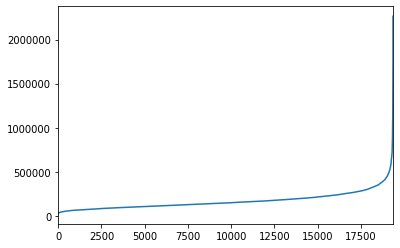

In [196]:
total_income_sum['total_income'].plot()

Разделим заемщиков на категории по доходу относительно медианного значения:
Доход не указан, Низкий, Ниже среднего, Средний, Выше среднего, Высокий

In [197]:
total_income_sum['total_income'].median()

145017.0

In [198]:
### функция для определения категории заемщика по уровню дохода
def income_catecory(row):
    income = row['total_income']
    if income < 0:
        return 'не указан'
    elif income <= 500e3:
        return 'до 500/низкий'
    elif income <= 1000e3:
        return 'от 500 до 1000/ниже среднего'
    elif income <= 1500e3:
        return 'от 1000 до 1500/средний'
    elif income <= 2000e3:
        return 'от 1500 до 2000/выше среднего'
    else:
        return 'от 2000/высокий'

In [199]:
solvency['income_category'] = solvency.apply(income_catecory, axis=1)

### Выделение словарей

In [200]:
# словарь "Семейное положение"
# выделение части таблицы, удаление дубликатов и приведение наименований к нжнему регистру
family_dict = solvency[['family_status', 'family_status_id']]
family_dict = family_dict.drop_duplicates().reset_index(drop=True)
family_dict['family_status'] = family_dict['family_status'].str.lower()
family_dict

,family_status,family_status_id
0,женат / замужем,0
1,гражданский брак,1
2,вдовец / вдова,2
3,в разводе,3
4,не женат / не замужем,4


### Шаг 3. Ответьте на вопросы

- Есть ли зависимость между наличием детей и возвратом кредита в срок?

In [201]:
# сформируем датесет, исключив из него заемщиков, по которым наличие детей неизвестно
children_rate = solvency.copy()
children_rate = children_rate[children_rate['children'] != -1]
# сформируем сводную таблицу - зависимость между наличием детей и возвратом кредита в срок
children_rate = pd.pivot_table(children_rate, 
                               index=['children'],
                               columns=['debt'], 
                               values='total_income', 
                               aggfunc='count', fill_value=0)
# присвоим столбцам заголовки
children_rate.set_axis(labels=['not_debt', 'debt',], axis='columns', inplace=True)
print('Зависимость между наличием детей и возвратом кредита в срок.')
print('')
print('в абсолютных значениях')
print(children_rate)
# представим зависимость в процентном выражении и отсортируем заемщиков по степени надежности
children_rate['total'] = children_rate['not_debt'] + children_rate['debt'] 
children_rate['debt_prc'] = round(children_rate['debt']*100/children_rate['total'], 2)
children_rate['not_debt_prc'] = round(children_rate['not_debt']*100/children_rate['total'], 2)
children_rate = children_rate.sort_values(by='not_debt_prc', ascending=False)
children_rate = children_rate[['not_debt_prc', 'debt_prc']]
print('')
print('в процентах (по степени надежности)')
print(children_rate)

Зависимость между наличием детей и возвратом кредита в срок.

в абсолютных значениях
          not_debt  debt
children                
0            13028  1063
1             4364   444
2             1858   194
3              303    27
4               37     4
5                9     0

в процентах (по степени надежности)
          not_debt_prc  debt_prc
children                        
5               100.00      0.00
0                92.46      7.54
3                91.82      8.18
1                90.77      9.23
2                90.55      9.45
4                90.24      9.76


### Вывод

Дисциплинированнее всего заемщики с 5 детьми, совсем без детей или с 3 детьми. Заемщики с 1, 2, 4 детьми менее дисциплинированные.

- Есть ли зависимость между семейным положением и возвратом кредита в срок?

In [202]:
fam_stat_rate = solvency.copy()
# сформируем сводную таблицу - зависимость между семейным положением и возвратом кредита в срок
fam_stat_rate = fam_stat_rate.pivot_table(
    index=['family_status_id'], 
    columns=['debt'], 
    values='family_status', 
    aggfunc='count')
# присвоим столбцам заголовки
fam_stat_rate.set_axis(labels=['not_debt', 'debt',], axis='columns', inplace=True)
print('Зависимость между семейным положением и возвратом кредита в срок.')
print('')
print('в абсолютных значениях')
print(fam_stat_rate)
# представим зависимость в процентном выражении и отсортируем заемщиков по степени надежности
fam_stat_rate['total'] = fam_stat_rate['not_debt'] + fam_stat_rate['debt']
fam_stat_rate['not_debt_prc'] = round(fam_stat_rate['not_debt']*100/fam_stat_rate['total'], 2)
fam_stat_rate['debt_prc'] = round(fam_stat_rate['debt']*100/fam_stat_rate['total'], 2)
# подстановка названия семейного положения из словаря
fam_stat_rate = fam_stat_rate.merge(family_dict, on='family_status_id', how='left')
fam_stat_rate = fam_stat_rate[['family_status', 'not_debt_prc', 'debt_prc']]
fam_stat_rate = fam_stat_rate.sort_values(by='not_debt_prc', ascending=False)
print('')
print('в процентах (по степени надежности)')
print(fam_stat_rate)

Зависимость между семейным положением и возвратом кредита в срок.

в абсолютных значениях
                  not_debt  debt
family_status_id                
0                    11408   931
1                     3763   388
2                      896    63
3                     1110    85
4                     2536   274

в процентах (по степени надежности)
           family_status  not_debt_prc  debt_prc
2         вдовец / вдова         93.43      6.57
3              в разводе         92.89      7.11
0        женат / замужем         92.45      7.55
1       гражданский брак         90.65      9.35
4  не женат / не замужем         90.25      9.75


### Вывод

Можно сделать вывод, что наиболее ответсвенные заемщики это вдовы/вдовцы, люди, находящиеся в разводе и состоящие в браке. А неженатые и проживающие в гражданском браке имеют более низкую платежную дисциплину.

- Есть ли зависимость между уровнем дохода и возвратом кредита в срок?

In [203]:
# сформируем сводную таблицу - зависимость между уровнем дохода и возвратом кредита в срок
total_income_rate = solvency.copy()
total_income_rate = total_income_rate[total_income_rate['total_income'] != -1]
total_income_rate = pd.pivot_table(total_income_rate, 
                                   index=['income_category'],
                                   columns=['debt'], 
                                   values='total_income', 
                                   aggfunc='count', 
                                   fill_value=0)
total_income_rate.set_axis(labels=['not_debt', 'debt',], axis='columns', inplace=True)
print('Зависимость между уровнем дохода и возвратом кредита в срок.')
print('')
print('в абсолютных значениях')
print(total_income_rate)
# расчет процента просрочек в общем количестве займов (по каждому семейному положению)
total_income_rate['total'] = total_income_rate['not_debt'] + total_income_rate['debt']
total_income_rate['not_debt_prc'] = round(total_income_rate['not_debt']*100/total_income_rate['total'], 2)
total_income_rate['debt_prc'] = round(total_income_rate['debt']*100/total_income_rate['total'], 2)
# подстановка названия семейного положения из словаря
total_income_rate = total_income_rate[['not_debt_prc', 'debt_prc']]
total_income_rate = total_income_rate.sort_values(by='not_debt_prc', ascending=False)
print('')
print('в процентах (по степени надежности)')
print(total_income_rate)

Зависимость между уровнем дохода и возвратом кредита в срок.

в абсолютных значениях
                               not_debt  debt
income_category                              
до 500/низкий                     17572  1557
от 1000 до 1500/средний              17     1
от 1500 до 2000/выше среднего         5     0
от 2000/высокий                       1     1
от 500 до 1000/ниже среднего        185    12

в процентах (по степени надежности)
                               not_debt_prc  debt_prc
income_category                                      
от 1500 до 2000/выше среднего        100.00      0.00
от 1000 до 1500/средний               94.44      5.56
от 500 до 1000/ниже среднего          93.91      6.09
до 500/низкий                         91.86      8.14
от 2000/высокий                       50.00     50.00


### Вывод

Как ни удивительно, но больше всего просрочек у заемщиков с высоким доходом.У заемщиков со средним доходом и доходом выше среднего просрочек меньше всего.

- Как разные цели кредита влияют на его возврат в срок?

In [204]:
purpose_rate = solvency.copy()
purpose_rate = pd.pivot_table(df, index='main_purpose', columns='debt', values='purpose', aggfunc='count')
purpose_rate
purpose_rate.set_axis(labels=['not_debt', 'debt',], axis='columns', inplace=True)
print('Зависимость между целью кредита и возвратом кредита в срок.')
print('')
print('в абсолютных значениях')
print(purpose_rate)
# расчет процента просрочек в общем количестве займов (по каждому семейному положению)
purpose_rate['total'] = purpose_rate['not_debt'] + purpose_rate['debt']
purpose_rate['not_debt_prc'] = round(purpose_rate['not_debt']*100/purpose_rate['total'], 2)
purpose_rate['debt_prc'] = round(purpose_rate['debt']*100/purpose_rate['total'], 2)
# подстановка названия семейного положения из словаря
purpose_rate = purpose_rate[['not_debt_prc', 'debt_prc']]
purpose_rate = purpose_rate.sort_values(by='not_debt_prc', ascending=False)
print('')
print('в процентах (по степени надежности)')
print(purpose_rate)

Зависимость между целью кредита и возвратом кредита в срок.

в абсолютных значениях
              not_debt  debt
main_purpose                
авто              3903   403
квартира         10029   782
свадьба           2138   186
учеба             3643   370

в процентах (по степени надежности)
              not_debt_prc  debt_prc
main_purpose                        
квартира             92.77      7.23
свадьба              92.00      8.00
учеба                90.78      9.22
авто                 90.64      9.36


### Вывод

Кредит на жилье имеет самый низкий уровень просрочки. Кредит на покупку автомобиля берут самые необязательные заемщики.

### Шаг 4. Общий вывод

- Мы получили портрет идеального заемщика: вдовец с 5 детьми, имеющий доход от 1500 до 2000 тыс., берущий кредит на покупку квартиры. Такой идеальный заемщик в нашей базе отсутствует.
- Что касается данных, то возможно в системе из которой поступают данные необходимо ввести контроль вводимых значений,  для полей 'children', добавить возможность помимо произвольного наименоваия цели устанавливать одну или несколько категорий целей из списка.

In [205]:
ideal = solvency.loc[(solvency.loc[:, 'children'] == 5)
                    & (solvency.loc[:, 'family_status_id'] == 2)
                    & (solvency.loc[:, 'income_category'] == 'от 1500 до 2000/выше среднего')
                    & (solvency.loc[:, 'main_purpose'] == 'квартира')]
ideal

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose,purpose_lemma,main_purpose,income_category


### Чек-лист готовности проекта

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x]  открыт файл;
- [x]  файл изучен;
- [x]  определены пропущенные значения;
- [x]  заполнены пропущенные значения;
- [x]  есть пояснение, какие пропущенные значения обнаружены;
- [x]  описаны возможные причины появления пропусков в данных;
- [x]  объяснено, по какому принципу заполнены пропуски;
- [x]  заменен вещественный тип данных на целочисленный;
- [x]  есть пояснение, какой метод используется для изменения типа данных и почему;
- [x]  удалены дубликаты;
- [x]  есть пояснение, какой метод используется для поиска и удаления дубликатов;
- [x]  описаны возможные причины появления дубликатов в данных;
- [x]  выделены леммы в значениях столбца с целями получения кредита;
- [x]  описан процесс лемматизации;
- [x]  данные категоризированы;
- [x]  есть объяснение принципа категоризации данных;
- [x]  есть ответ на вопрос: "Есть ли зависимость между наличием детей и возвратом кредита в срок?";
- [x]  есть ответ на вопрос: "Есть ли зависимость между семейным положением и возвратом кредита в срок?";
- [x]  есть ответ на вопрос: "Есть ли зависимость между уровнем дохода и возвратом кредита в срок?";
- [x]  есть ответ на вопрос: "Как разные цели кредита влияют на его возврат в срок?";
- [x]  в каждом этапе есть выводы;
- [x]  есть общий вывод.